In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("/content/IMDB Dataset.csv")
# show basic info
print(df.head())
print(f'shape of dataset is {df.shape}')
print(df.describe())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
shape of dataset is (50000, 2)
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


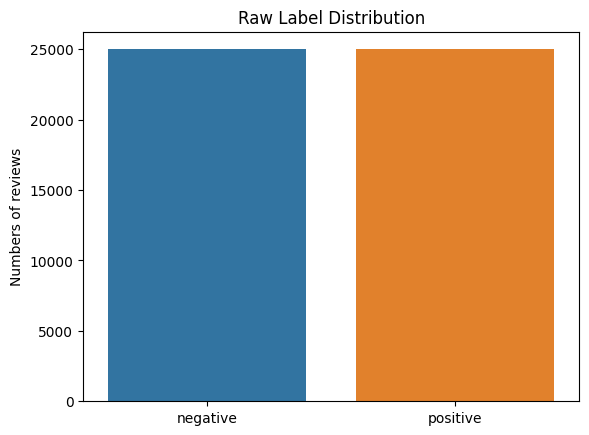

In [3]:
review, label = df['review'].values, df['sentiment'].values
raw_label = pd.Series(label).value_counts()
sns.barplot(x=np.array(['negative', 'positive']), y=raw_label.values)
plt.title("Raw Label Distribution")
plt.ylabel("Numbers of reviews")
plt.show()

# divide attribute and label
X, y = df['review'], df['sentiment']

In [4]:
# data preprocess
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# preprocessing data
X = X.apply(denoise_text)
print("denoise completed")
reviews = X.apply(remove_special_characters)
print("special characters removed")
print("stopwords removed")
print(reviews.head)

# convert label from pos & neg to 1 & 0
lb = LabelBinarizer()
# transformed sentiment data
sentiment_data = lb.fit_transform(y)
print('Label set:', sentiment_data.shape)

denoise completed
special characters removed
<bound method NDFrame.head of 0        one of the other review ha mention that after ...
1        a wonder littl product the film techniqu is ve...
2        i thought thi wa a wonder way to spend time on...
3        basic there a famili where a littl boy jake th...
4        petter mattei love in the time of money is a v...
                               ...                        
49995    i thought thi movi did a down right good job i...
49996    bad plot bad dialogu bad act idiot direct the ...
49997    i am a cathol taught in parochi elementari sch...
49998    im go to have to disagre with the previou comm...
49999    no one expect the star trek movi to be high ar...
Name: review, Length: 50000, dtype: object>
stopwords removed
Label set: (50000, 1)


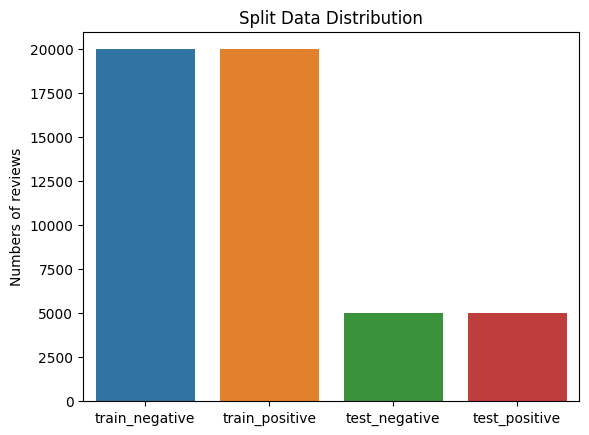

In [12]:
# Splitting data
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(X, sentiment_data, stratify=sentiment_data, test_size=0.2)

# split data visualization
training_label = pd.Series(train_sentiments.squeeze()).value_counts()
test_label = pd.Series(test_sentiments.squeeze()).value_counts()
height = [training_label[0], training_label[1], test_label[0], test_label[1]]
sns.barplot(x=np.array(['train_negative', 'train_positive', 'test_negative', 'test_positive']), y=height)
plt.title("Split Data Distribution")
plt.ylabel("Numbers of reviews")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


val_acc: 0.90610 f1_score: 0.90610
              precision    recall  f1-score   support

           0     0.9158    0.8944    0.9050      5000
           1     0.8968    0.9178    0.9072      5000

    accuracy                         0.9061     10000
   macro avg     0.9063    0.9061    0.9061     10000
weighted avg     0.9063    0.9061    0.9061     10000



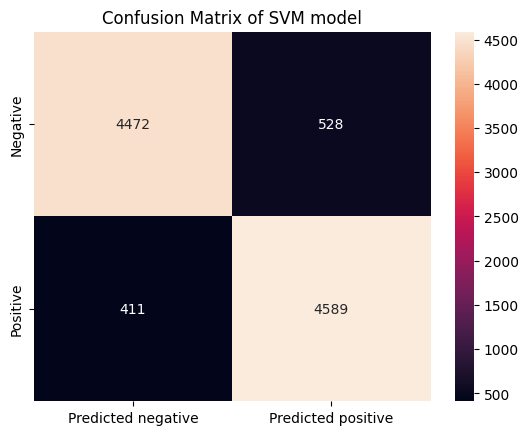

In [13]:
# BoW method
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1, 3)),
                               TfidfTransformer(),
                               LinearSVC()).fit(train_reviews, train_sentiments)

predicted = baseline_model.predict(test_reviews)

val_acc = accuracy_score(test_sentiments, predicted)
val_f1_score = f1_score(test_sentiments, predicted, average='micro')

print(f'val_acc: {val_acc:.5f} f1_score: {val_f1_score:.5f}')
print(classification_report(test_sentiments, predicted, digits=4))

sns.heatmap(confusion_matrix(test_sentiments, predicted),
            annot=True, fmt='.0f',
            xticklabels=['Predicted negative', 'Predicted positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix of SVM model")
plt.show()

In [23]:
# preprocessing LSTM data
df['review_500'] = reviews.apply(lambda x:x[:500])

df['review_500'][0]

'one of the other review ha mention that after watch just 1 oz episod youll be hook they are right as thi is exactli what happen with meth first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go trust me thi is not a show for the faint heart or timid thi show pull no punch with regard to drug sex or violenc it is hardcor in the classic use of the wordit is call oz as that is the nicknam given to the oswald maximum secur state penitentari '

In [24]:
tokenizer = Tokenizer(num_words=10000)

In [31]:
tokenizer.fit_on_texts(df['review_500'])
seq = tokenizer.texts_to_sequences(df['review_500'])
X = pad_sequences(seq, padding='post')
y = sentiment_data

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}, y: {y.shape}')

X_shape: (50000, 122), X_min: 0, X_max: 9999, y: (50000, 1)


In [54]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(f'X_train: {X_train.shape}, X_valid: {X_valid.shape}, X_test: {X_test.shape}')

X_train: (32000, 122), X_valid: (8000, 122), X_test: (10000, 122)


In [33]:
y_train

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [45]:
# LSTM v1 structure
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673089 (2.57 MB)
Trainable params: 673089 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1000/1000 [==============================] - 121s 118ms/step - loss: 0.4550 - accuracy: 0.7822 - val_loss: 0.3811 - val_accuracy: 0.8347
Epoch 2/5
1000/1000 [==============================] - 97s 97ms/step - loss: 0.3214 - accuracy: 0.8652 - val_loss: 0.3821 - val_accuracy: 0.8289
Epoch 3/5
1000/1000 [==============================] - 101s 101ms/step - loss: 0.2553 - accuracy: 0.8955 - val_loss: 0.3976 - val_accuracy: 0.8183
Epoch 4/5
1000/1000 [==============================] - 124s 124ms/step - loss: 0.1964 - accuracy: 0.9237 - val_loss: 0.4749 - val_accuracy: 0.8240
Epoch 5/5
1000/1000 [==============================] - 103s 104ms/step - loss: 0.1538 - accuracy: 0.9433 - val_loss: 0.6016 - val_accuracy: 0.8219


<Axes: >

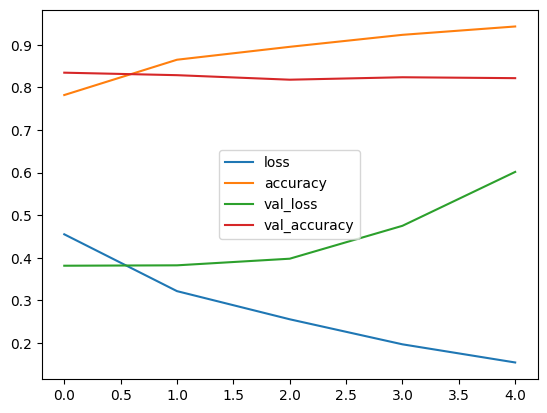

In [48]:
# Training history of LSTM v1
pd.DataFrame(history.history).plot()

313/313 [==============================] - 11s 34ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4961
           1       0.82      0.82      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Text(0.5, 1.0, 'Confusion Matrix of LSTM v1')

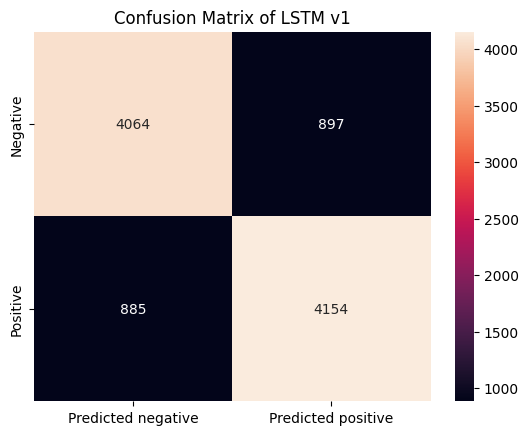

In [52]:
# LSTM v1 result
y_pred = model.predict(X_test)
y_pred = np.int64(y_pred>0.5)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='.0f',
            xticklabels=['Predicted negative', 'Predicted positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix of LSTM v1")

In [49]:
# updated LSTM to reduce overfitting
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 spatial_dropout1d (Spatial  (None, None, 64)          0         
 Dropout1D)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673089 (2.57 MB)
Trainable params: 673089 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
500/500 [==============================] - 134s 262ms/step - loss: 0.6272 - accuracy: 0.6302 - val_loss: 0.4957 - val_accuracy: 0.7765
Epoch 2/20
500/500 [==============================] - 115s 229ms/step - loss: 0.4412 - accuracy: 0.8073 - val_loss: 0.4033 - val_accuracy: 0.8207
Epoch 3/20
500/500 [==============================] - 118s 237ms/step - loss: 0.3770 - accuracy: 0.8390 - val_loss: 0.3844 - val_accuracy: 0.8289
Epoch 4/20
500/500 [==============================] - 115s 231ms/step - loss: 0.3408 - accuracy: 0.8577 - val_loss: 0.3787 - val_accuracy: 0.8298
Epoch 5/20
500/500 [==============================] - 127s 254ms/step - loss: 0.3169 - accuracy: 0.8684 - val_loss: 0.3792 - val_accuracy: 0.8307
Epoch 6/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2988 - accuracy: 0.8788 - val_loss: 0.4080 - val_accuracy: 0.8291
Epoch 7/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2886 - accuracy: 0.8838 - val_loss: 0.3798 -

<Axes: >

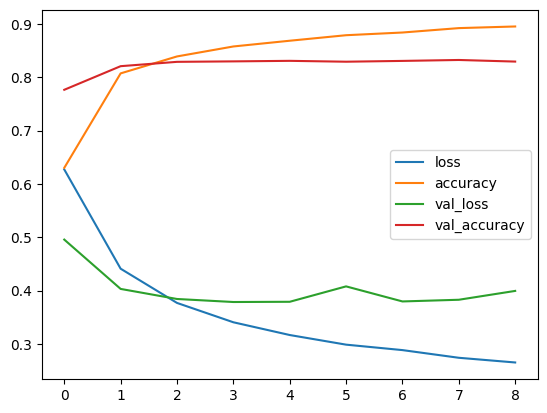

In [51]:
pd.DataFrame(history.history).plot()

313/313 [==============================] - 12s 35ms/step
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4961
           1       0.84      0.83      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



Text(0.5, 1.0, 'Confusion Matrix of LSTM v2')

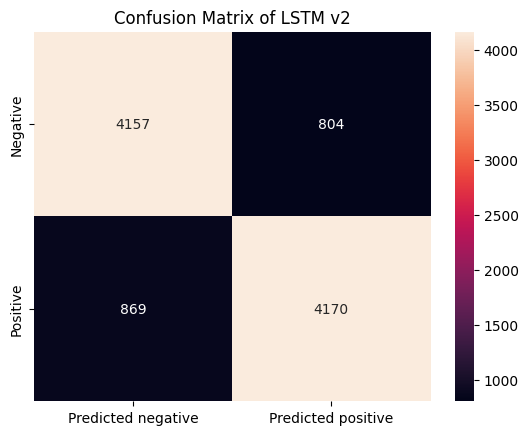

In [56]:
y_pred = model_v2.predict(X_test)
y_pred = np.int64(y_pred>0.5)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='.0f',
            xticklabels=['Predicted negative', 'Predicted positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix of LSTM v2")